#  COMP24112 Lab 2: News Article Classification by k-NN

## 1. Task description

You will work on a news article classification task.
The provided dataset includes a total of 800 articles taken from Reuters newswire.
They belong to 4 classes: "earn" (0), "crude" (1), "trade" (2) and "interest" (3).
There are 200 articles per class.
Each article is characterised by word occurrences.
The list of used words is called a vocabulary.
In our dataset, the vocabulary includes a total of 6428 words. 

## 2. Preparation

First we need to import the data.
Run the below cell to load the data using NumPy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

# data, (0, 1, 2, 3), (earn, crude, trade, interest)
data, labels, class_names, vocabulary = np.load("ReutersNews_4Classes_sparse.npy", allow_pickle=True)

### A Note on Sparsity

Most documents only contain a small subset of the vocabulary, resulting in a very sparse data matrix.
To handle the sparsity, in this exercise `data` is represented as a `scipy.sparse.csr_matrix`, which can store sparse matrices efficiently while still allowing efficient row-based indexing.
You can learn more about `csr_matrix` and other ways of dealing with sparse matrices at https://docs.scipy.org/doc/scipy/reference/sparse.html.

Note, however, that `data` is **not** a normal NumPy array.
While most operations will be the same as with a normal dense array, **you cannot use a sparse matrix to index another matrix**.
If you need to do this, either first convert the matrix to a NumPy array with the `toarray()` method, or use methods specifically designed to work with sparse matrices.

In [2]:
print(data[41,:]) # A sparse row vector; the output will be the non-zero indices and their values.
print(data[41,:].toarray()) # Convert back to a NumPy array. Note that the result is a (1, 6428) matrix, not a vector.
# print(vocabulary[data[41,:] > 0]) # Can't index vocabulary with a sparse matrix.
rows, columns, values = scipy.sparse.find(data[41,:]) # Find the non-zero entries in the 42nd document.
print(vocabulary[columns]) # Prints the words present in the 42nd document.

  (0, 2)	1
  (0, 3)	3
  (0, 5)	1
  (0, 8)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 21)	2
  (0, 24)	1
  (0, 105)	1
  (0, 127)	1
  (0, 227)	1
  (0, 275)	1
  (0, 334)	2
  (0, 341)	1
  (0, 348)	1
  (0, 359)	1
  (0, 411)	1
  (0, 426)	1
  (0, 1428)	1
  (0, 2058)	1
  (0, 5555)	1
[[0 0 1 ... 0 0 0]]
['share' 'split' 'say' 'two-for-one' 'shareholder' 'annual' 'meeting'
 'reuter' 'ct' 'note' 'company' 'pay' 'subject' 'increase' 'stock'
 'dividend' 'april' 'northern' 'declare' 'approval' 'telecom' 'post-split'
 'nt']


To see the full vocabulary, you can run

In [3]:
print(", ".join(vocabulary))

island, telephone, share, split, approve, say, previously, announce, two-for-one, common, shareholder, annual, meeting, reuter, year, net, shr, loss, nil, vs, profit, ct, rev, mln, note, current, include, charge, discontinue, operation, dlr, ec, state, tax, majority, european, community, member, strong, reservation, import, domestically-produced, oil, fat, propose, commission, senior, diplomat, special, committee, agricultural, expert, voice, objection, measure, prepare, ground, farm, begin, monday, add, france, italy, indicate, support, proposal, lead, initially, tonne, 1987/88, price, round, complete, sale, french, unit, business, compagnie, francaise, group, investor, employee, minnesota, disclose, term, deal, plan, asset, electronic, shoe, town, end, jan, respectively, december, wisconsin, fwb, buy, bank, corp, acquire, bancshare, cash, acquisition, hold, company, total, billion, purchase, time, earning, office, paul, area, american, product, 3rd, qtr, period, feb, mth, avg, 4th, s

You can see how many times article $i$ contains word $j$ using

In [4]:
i, j = 40, 2
print(data[i,j])

4


You can see which class the $i$th article belongs to using

In [5]:
print(labels[i])

0


For instance, by running

In [6]:
print("Occurrences:", data[0,10])
print("Class:", class_names[labels[0]])
print("Word:", vocabulary[10])

Occurrences: 2
Class: earn
Word: shareholder


you can see that the 11th word appears twice in the first document, the first document belongs to the class "earn", and the 11th word is "shareholder".

The following function randomly selects a subset of the data.

In [7]:
def sample_indices(labels, *num_per_class):
    """
    Returns randomly selected indices. It will return the specified number of indices for each class.
    """
    indices = []
    for cls, num in enumerate(num_per_class):
        cls_indices = np.where(labels == cls)[0]
        indices.extend(np.random.choice(cls_indices, size=num, replace=False))
    return np.array(indices)

For instance, to get one sample from the first class, two from the second, three from the third, and four from the fourth, you can run:

In [8]:
indices = sample_indices(labels, 1, 2, 3, 4)
print("Returned indices:", indices)
print("Samples:", data[indices])
print("Corresponding classes:", labels[indices])

Returned indices: [139 268 308 585 428 413 659 796 674 712]
Samples:   (0, 13)	1
  (0, 19)	1
  (0, 21)	2
  (0, 127)	1
  (0, 157)	1
  (0, 330)	1
  (0, 341)	2
  (0, 349)	1
  (0, 622)	2
  (0, 798)	1
  (0, 2183)	1
  (0, 2370)	1
  (0, 2869)	2
  (0, 4205)	1
  (1, 5)	2
  (1, 13)	1
  (1, 21)	1
  (1, 30)	2
  (1, 42)	3
  (1, 70)	2
  (1, 79)	1
  (1, 105)	1
  (1, 151)	3
  (1, 215)	1
  (1, 275)	1
  :	:
  (9, 3047)	1
  (9, 3095)	1
  (9, 3162)	1
  (9, 3163)	1
  (9, 3165)	2
  (9, 3203)	1
  (9, 3242)	1
  (9, 3298)	1
  (9, 3465)	1
  (9, 3549)	2
  (9, 4116)	1
  (9, 4624)	1
  (9, 4757)	1
  (9, 4844)	1
  (9, 4920)	1
  (9, 4921)	2
  (9, 4922)	1
  (9, 4923)	1
  (9, 4924)	1
  (9, 4925)	1
  (9, 4926)	1
  (9, 4927)	1
  (9, 4928)	1
  (9, 4929)	3
  (9, 4930)	1
Corresponding classes: [0 1 1 2 2 2 3 3 3 3]


## 3. k-NN Implementation (4 Marks, Normal)

Now, you will need to implement a k-NN classifier by filling the code below.
This function should support two types of distance measures: Euclidean distance and cosine distance (defined as 1 - cosine similarity). It should take a set of training samples, a user-specified neighbour number, a distance option, and features of a set of testing samples as the input.
It should return the predicted classes for the input set of testing samples.

In order to get 4 marks, you are asked to implement the k-NN classifier from scrach without relying on any machine learning library, particularly the distance calculation. But you are allowed to research NumPy functions relating to sorting. If you decide to use existing distance implementation from libraries, e.g., `sklearn.metrics.pairwise_distances` imported as `cdist`, you can get at most 3 marks.

**Your implementation must NOT make use of Python loops over individual samples or features**.
You should use functions that operate on whole matrices, as this will be much faster than looping in Python.
Each experiment below is expected to take no more than 2 minutes to run.

In [9]:
def distance_matrix(A, B, metric, squared=False):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.
    """
    
    if metric == "euclidean":
        # Check if two matrices are matched         
        assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
            {A.shape[1]} does not match that of B {B.shape[1]}!"

        D_squared = np.sqrt(np.sum(A.power(2), axis=1) - 2 * np.dot(A,B.T) + np.sum(B.power(2), axis=1).T)

    elif metric == "cosine":
        # Calculate the norms of each row of A and B
        norms_A = np.sqrt(np.sum(A.power(2), axis=1))
        norms_B = np.sqrt(np.sum(B.power(2), axis=1)) 
 
        # Calculate the outer product of the norms of A and B
        outer_product = norms_A.dot(norms_B.T)
        D_squared = 1 - A.dot(B.T) / outer_product
                     
    return D_squared

In [10]:
import scipy.stats

def knn_classify(test_samples, training_data, training_labels, metric="euclidean", k=1):
    """
    Performs k-nearest neighbour classification on the provided samples,
    given training data and the corresponding labels.
    
    test_samples: An m x d matrix of m samples to classify, each with d features.
    training_data: An n x d matrix consisting of n training samples, each with d features.
    training_labels: A vector of size n, where training_labels[i] is the label of training_data[i].
    metric: The metric to use for calculating distances between samples.
    k: The number of nearest neighbours to use for classification.
    
    Returns: A vector of size m, where out[i] is the predicted class of test_samples[i].
    """
    # Calculate an m x n distance matrix.
    pairwise_distance = distance_matrix(test_samples, training_data, metric=metric)    
    # Find the k nearest neighbours of each samples as an m x k matrix of indices.
    nearest_neighbours = np.argpartition(pairwise_distance, k)[:, :k]
    
    # Look up the classes corresponding to each index.
    nearest_labels = training_labels[nearest_neighbours]

    # Return the most frequent class on each row.
    # Note: Ensure that the returned vector does not contain any empty dimensions.
    # You may find the squeeze method useful here.
    return np.squeeze(np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=nearest_labels))


In [11]:
def choose_data(data, labels, *num_per_class):
    """
    Generate 2 kinds of data and 2 kinds of labels according to how many articles per class for training and test

    num_per_class: number of articles per class for training
    """
    training_index = sample_indices(labels, *num_per_class)
    training_data = data[training_index]
    training_labels = labels[training_index]
    
    test_index = [i for i in range(len(labels)) if i not in training_index]
    test_data = data[test_index]
    test_labels = labels[test_index]
    return training_data, training_labels, test_data, test_labels

## 4. Experiments (13 Marks in Total)

Use your k-NN function to perform the following experiments.

### Experiment 1 (3 Marks, Easy)

Randomly select 80 articles per class for training, and use the remaining articles for testing.
Fix a neighbour number setting as you see fit. Perform k-NN classification using the Euclidean distance and test it.

Repeat this process 20 times (trials).
Calculate the mean and standard deviation of the testing accuracies. Print out the mean and standard deviation.

In [12]:
def knn_perform1(times, metric, k, *num_per_class):
    # The accuracy of each time saves in a list    
    accuracy = []
    for i in range(times):
        training_data, training_labels, test_data, test_labels = choose_data(data, labels, *num_per_class)      
        predicted_class = knn_classify(test_data, training_data, training_labels, metric, k)
        
        # Compare with test labels then decide if it is consist        
        accuracy.append(np.sum(predicted_class == test_labels) / len(predicted_class))
    return np.array(accuracy)

In [13]:
accuracy_euclidean = knn_perform1(20, "euclidean", 5, 80, 80, 80, 80)
print("mean of the testing accuracies with Euclidean distance:", np.mean(accuracy_euclidean))
print("standard deviation(sd.) of the testing accuracies with Euclidean distance:", np.std(accuracy_euclidean))

mean of the testing accuracies with Euclidean distance: 0.8608333333333335
standard deviation(sd.) of the testing accuracies with Euclidean distance: 0.028984550482397807


Use the same neighbour number, but use the cosine distance instead of the Euclidean distance.
Repeat the same experiment.

Print out the mean and standard deviation.

In [14]:
accuracy_cosine = knn_perform1(20, "cosine", 5, 80, 80, 80, 80)
print("mean of the testing accuracies with cosine distance:", np.mean(accuracy_cosine))
print("standard deviation(sd.) of the testing accuracies with cosine distance:", np.std(accuracy_cosine))

mean of the testing accuracies with cosine distance: 0.9617708333333331
standard deviation(sd.) of the testing accuracies with cosine distance: 0.007858199671892604


Explain in your report which distance measure gives better performance and analyse the reason. 

### Experiment 2 (5 Marks, Easy)

Using the distance measure that you found performs better in Experiment 1.

Randomly select 80 articles per class for training, and use the remaining articles for testing. Perform k-NN classification with the neighbour number $k$ varying from 1 to 50.

For each values of $k$, repeat the training process by 20 trials and record the average training error rates and standard deviation.

Do the same for testing errors.

In [15]:
def knn_perform2(times, metric, *nums):
    average_training_errors, average_test_errors = [], []
    sd_training_errors, sd_test_errors = [], []
    for k in range(1, 51):
        train_err, test_err = [], []
        for _ in range(times):
            training_data, training_labels, test_data, test_labels = choose_data(data, labels, *nums)
            # Use training data twice: implement it as both test samples and training_data
            predicted_class = knn_classify(training_data, training_data, training_labels, metric, k)
            train_err.append(np.sum(predicted_class != training_labels) / len(predicted_class))

            predicted_class = knn_classify(test_data, training_data, training_labels, metric, k)
            test_err.append(np.sum(predicted_class != test_labels) / len(predicted_class))
            
        # Record the average training error rates    
        average_training_errors.append(np.mean(np.array(train_err)))
        average_test_errors.append(np.mean(np.array(test_err)))
        # Record the standard deviation         
        sd_training_errors.append(np.std(np.array(train_err)))
        sd_test_errors.append(np.std(np.array(test_err)))

    return average_training_errors, sd_training_errors, average_test_errors, sd_test_errors

In [16]:
# According to Experiment1's result, "cosine" performs better
# better_metric = "cosine"
better_metric = "cosine" if np.mean(accuracy_cosine) > np.mean(accuracy_euclidean) else "euclidean"

# Randomly select 80 articles per class for training,
average_training_errors, sd_training_errors, average_test_errors, sd_test_errors = knn_perform2(20, better_metric, 80, 80, 80, 80)

Produce an error bar plot showing the training error rate for each $k$ here:

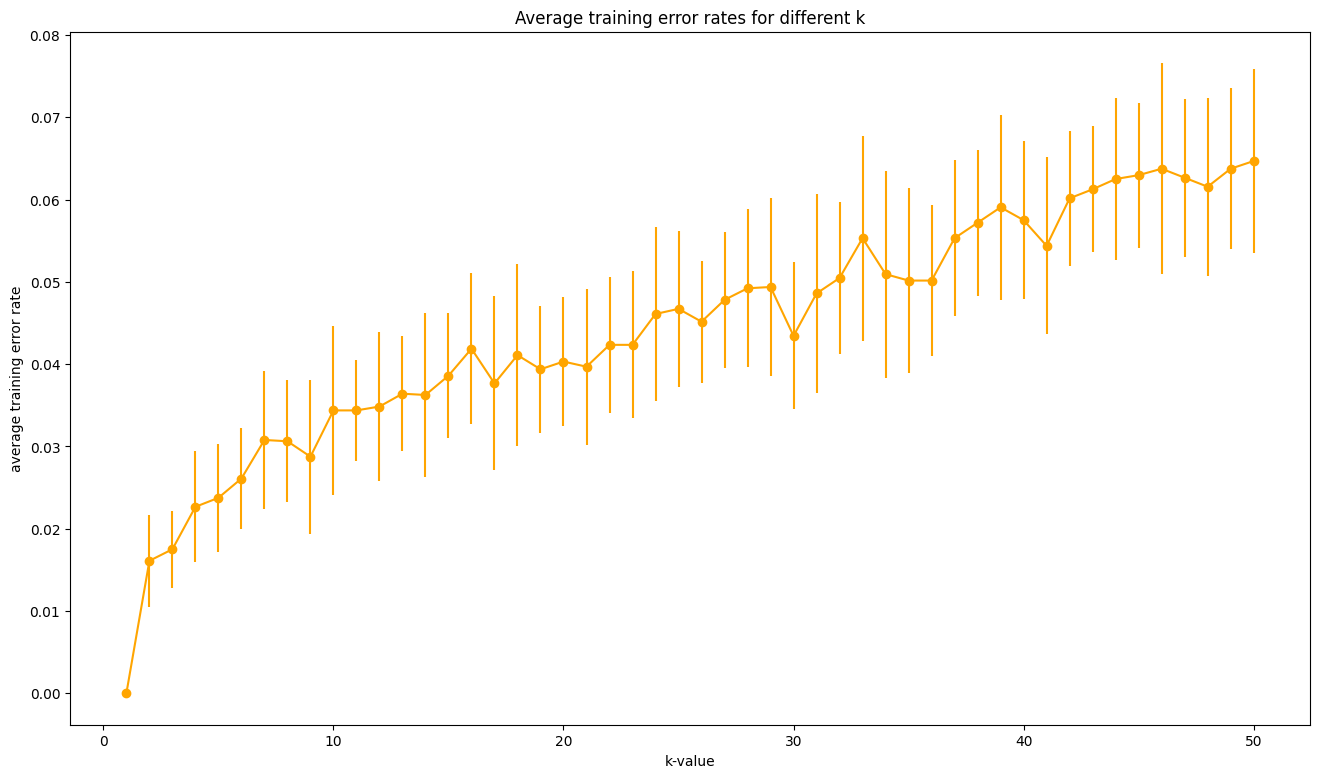

In [17]:
plt.figure(figsize=(16,9))
plt.errorbar(range(1, 51), average_training_errors, yerr = sd_training_errors, marker = "o", color = 'orange')
plt.xlabel("k-value")
plt.ylabel("average training error rate")
plt.title("Average training error rates for different k")
plt.show()

Produce your testing error bar plot here:

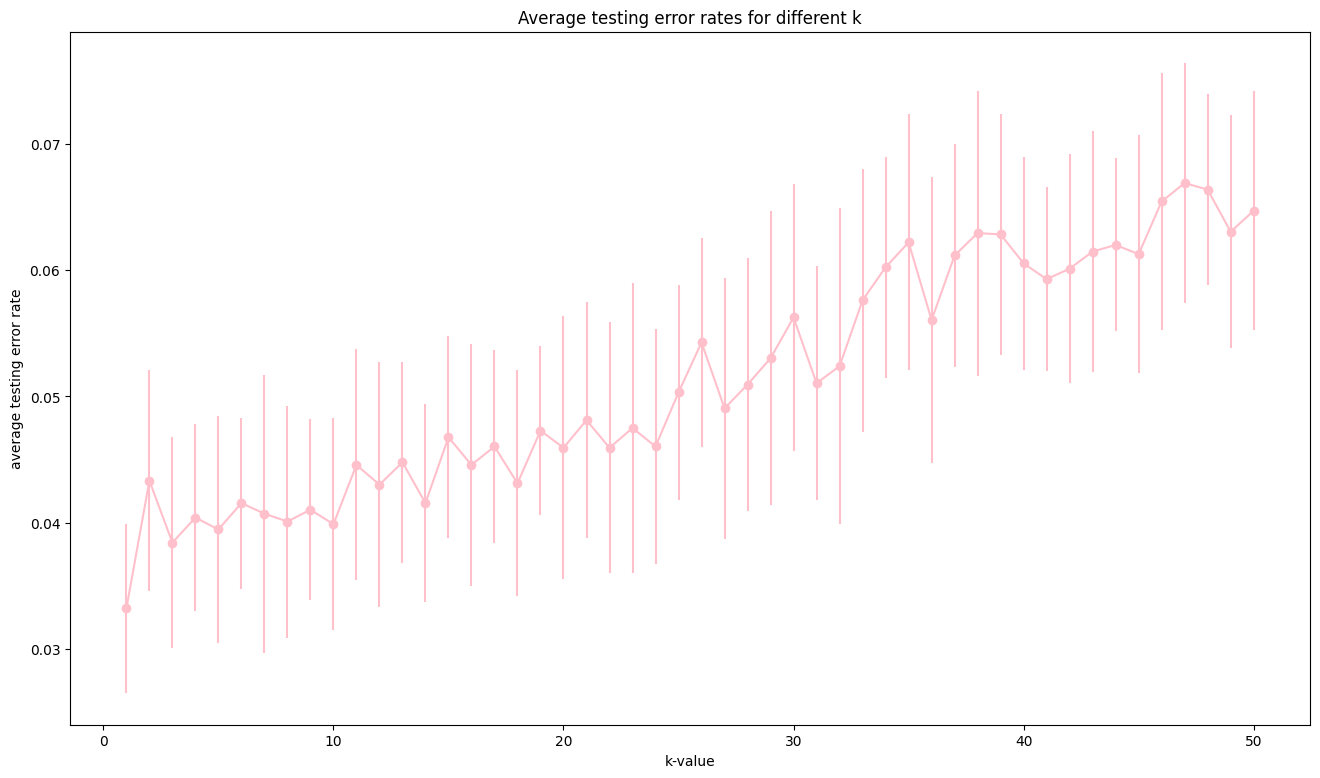

In [18]:
plt.figure(figsize=(16,9))
plt.errorbar(range(1, 51), average_test_errors, yerr = sd_test_errors, marker = "o", color = 'pink')
plt.xlabel("k-value")
plt.ylabel("average testing error rate")
plt.title("Average testing error rates for different k")
plt.show()

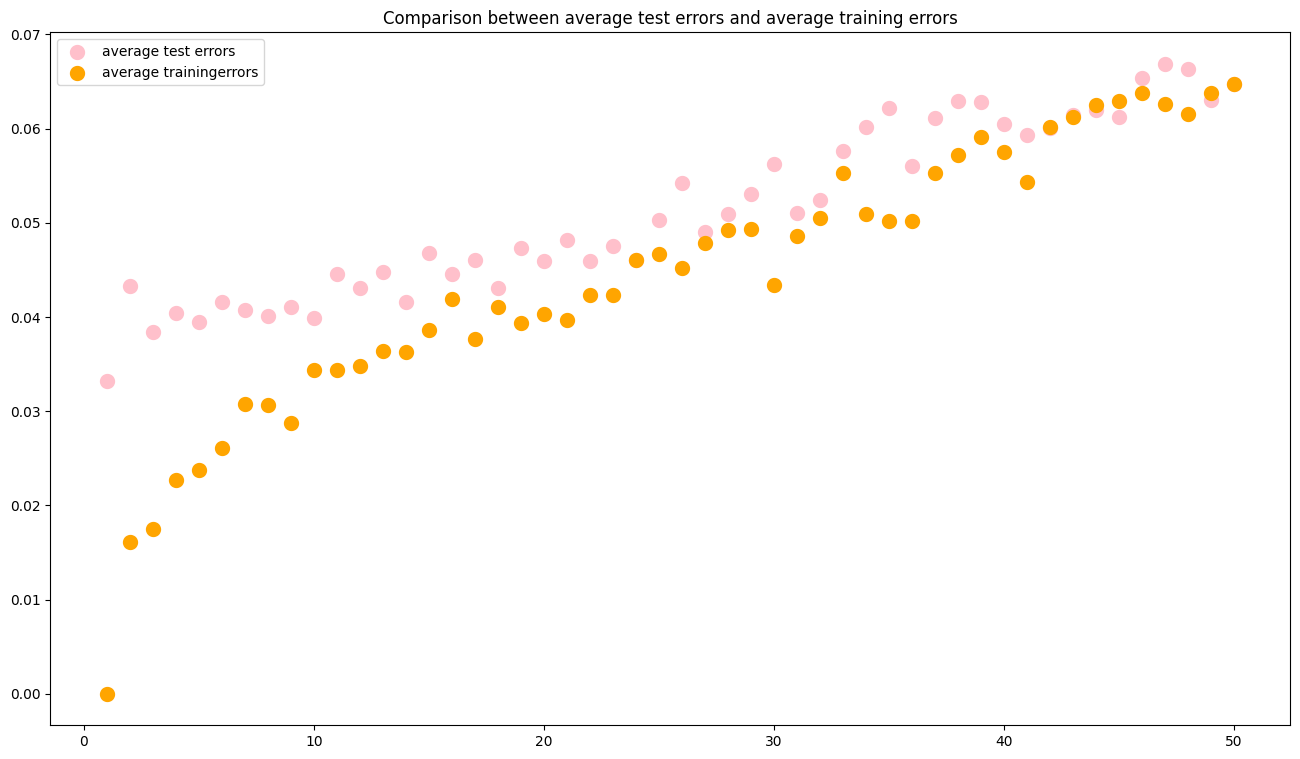

In [19]:
plt.figure(figsize=(16,9))
p1 = plt.scatter(range(1, 51), average_test_errors, linewidths=5, c='pink')
p2 = plt.scatter(range(1, 51), average_training_errors, linewidths=5,c='orange')
plt.title("Comparison between average test errors and average training errors")
plt.legend((p1,p2),('average test errors','average trainingerrors') ,loc = 'best')

**Remember that all graphs should have axis labels and a title.**

Discuss in your report the difference between the training and testing accuracies, and why this is the case. 

Analyse in your report the effect of $k$ based on this experiment. What do you think is a reasonable value for $k$? Comment specifically on the *bias* and *variance* of your model at small and large values of $k$.

### Experiment 3 (5 Marks, Hard)

In this experiment we will create confusion matrices for a more detailed view on our model's performance. Then, we will observe the behaviour of our knn classifier on novel classes.

First, randomly select 100 articles per class for training, and use the remaining articles for testing. Set the neighbour number to $k=3$. Perform 3-NN classification using the Cosine distance, as in previous experiments.

#### Confusion Matrix Implementation  

Implement a multi-class confusion matrix yourself, from scratch. Let the row index correspond to the known label, and column index to predicted label. If you decide to use existing confusion matrix implementation from libraries, e.g., `sklearn.metrics.confusion_matrix`, you can get at most 4 marks. (However, you may use an existing implementation to check the output of your own function.)

Print out the confusion matrix and overall accuracy of your classifier for the testing data.

In [20]:
# randomly select 100 articles per class for training, and use the remaining articles for testing.
training_data3, training_labels3, test_data3, test_labels3 = choose_data(data, labels, 100, 100, 100, 100)
y_true = test_labels3
y_pred = knn_classify(test_data3, training_data3, training_labels3, "cosine", 3)

In [21]:
def confusion_matrix_scratch(y_true, y_pred):
    # Get the set of unique labels
    labels = sorted(list(set(y_true)))
    labels_len = len(labels)
    # Initialize the confusion matrix as a 2D numpy array
    matrix = np.zeros((labels_len, labels_len), dtype=int)
    # Fill in the matrix
    for i in range(len(y_true)):
        matrix[y_true[i]][y_pred[i]] += 1
    return matrix

In [22]:
# Implement a multi-class confusion matrix by myself!!!
confusion_matrix_scratch(y_true, y_pred)

array([[95,  0,  2,  3],
       [ 0, 98,  1,  1],
       [ 0,  4, 95,  1],
       [ 1,  0,  3, 96]])

In [23]:
accuracy = np.sum(y_pred == y_true) / len(y_pred)
print("overall accuracy:", accuracy)

overall accuracy: 0.96


#### On Novel Classes

5 new articles have been provided in string format below. The code to create a sparse representation of these articles has also been provided. Take a moment to skim through the articles.

Run the code below, saving the sparse matrix representation of these 5 articles into `new_data`.

In [24]:
sp0 = """World number four Jessica Pegula said she thought about ending her tennis career prematurely last year due to her mother Kim's health issues.
Kim, the co-owner and president of the NFL's Buffalo Bills and NHL's Buffalo Sabres, suffered a cardiac arrest in June and needed CPR from her other daughter Kelly before paramedics arrived and restored her heartbeat.
Pegula received the news after returning home to Florida from the French Open, where she lost to eventual champion Iga Swiatek but rose to number eight in the world.
"Suddenly I went from, 'Let's celebrate top 10 in the world' to, 'Do I need to start thinking about my career after tennis a lot sooner than I thought?'" Pegula wrote in an essay in The Players' Tribune.
"I'm 28 and I take pride in being able to handle every situation thrown at me, but this was a lot."
Pegula said she wanted to share her mother's story after Bills safety Damar Hamlin suffered a cardiac arrest during an NFL game last month.
Pegula went on to play Wimbledon and the U.S. Open last year to reach a career-high ranking of number three.
"I still wanted to play Wimbledon if I knew my mom was O.K.," Pegula wrote. "My dad didn't want me to play, but I knew she would be upset if I skipped because of her.
"I had to deal with a lot of speculation and questions surrounding her health, even shutting down rumours that she had died," added Pegula, who lost to Victoria Azarenka in the quarter-finals of this year's Australian Open.
"It wasn't necessarily the most fun Wimbledon experience I remember. I had a few good wins, and I was proud I was able to go out and compete considering the situation." """

sp1 = """Juventus outclassed Salernitana 3-0 on Tuesday in Serie A, with two goals and one assist from striker Dusan Vlahovic helping the visitors move up to 10th place in the standings. The game marked a return to form for Serbian Vlahovic, who has struggled with injuries this season, but made his first league start since October. 
"You can see physically, he just moves better, looks sharper, he also played well on a technical level today," Juventus manager Massimiliano Allegri told DAZN.
Juventus got a penalty after 26 minutes when Hans Nicolussi fouled Manuel Locatelli inside the box with Vlahovic converting the penalty.
Vlahovic almost netted a second in the 37th minute, but his shot from an acute angle at the edge of the box went just wide of the post.
Filip Kostic doubled the lead on the stroke of halftime when he tapped the ball in from close range after Vlahovic's initial shot bounced into his path, providing an unintended assist.
Juventus could have scored a third in the last seconds before the break when Locatelli made a run unmarked into the box, but Salernitana keeper Guillermo Ochoa reacted early and parried his attempted lob.
Vlahovic got his second goal 80 seconds into the second half when he ran through in the box and smashed the ball low into the right corner.
Salernitana almost pulled one back in the 51st minute, with Junior Sambia sending a cross that went through almost everyone in the box, but forward Boulaye Dia was unable to stretch himself in time to guide the ball into the open net.
"The team gave a strong response, we had a good 60 minutes, but got a bit complacent after going 3-0 up and allowed too many shots on goal. We were static in our positions, didn't move around enough and the players know we must absolutely do better," Allegri said.
"The first 10 minutes we tended to pass it too much down the right, so we need to improve our passing, be smoother and keep it simple."
Juve could have added to their tally but were denied by the woodwork with Angel Di Maria hitting the crossbar after 53 minutes and Moise Kean striking the post late on.
The result moved Juventus on to 26 points from 21 matches, while Salernitana are 16th with 21 points." """

sp2 = """Manchester United manager Erik ten Hag said he has a long-term plan to build a culture and to develop players at the club.
United appointed Ten Hag in April 2022 to succeed interim boss Ralf Rangnick.
The team sit third in the Premier League, eight points behind leaders Arsenal, and have the chance to win their first trophy since 2017 when they face Newcastle United in the League Cup final on Feb. 26.
"I always think about the long term, in every club where I was, I have been thinking about long-term work to build a culture, to build a way of playing, to develop the players and the team, obviously," Ten Hag told reporters.
"I think in the long term obviously in contracts and in (transfer) windows because I think that is the (right) way.
"I am not here for one year, I am (here for) longer, I see it is a long-term project to build here and how long it is you can't see, I can't tell," he added."""

sp3 = """A near-historic Philadelphia Eagles pass rush will face the ultimate test on Sunday in Kansas City Chiefs quarterback Patrick Mahomes, an MVP favourite with no interest in ceding the Super Bowl spotlight.
The Eagles established themselves as a terrifying defensive force in the regular season, punishing opponents with an astonishing 70 sacks, two shy of the NFL record, while allowing the second-fewest yards per game.
But Mahomes is unlike any quarterback they faced in 2022.
"Mahomes is the guy that extends the plays and drops the dimes," defensive end Brandon Graham, who helped the Eagles to the Lombardi Trophy five years ago, told reporters on Tuesday.
"You've got to make sure you can hit him, get him on the ground, create turnovers, make him make bad throws."
At just 27-years-old Mahomes has already vaulted himself into the history books, joining future Hall of Famer Drew Brees this year as one of only two quarterbacks to throw for more than 5,000 yards and 40 or more touchdowns in multiple seasons.
Eagles linebacker Haason Reddick produced a career-best 16 sacks this season but had few answers when asked how the Eagles could contain Mahomes.
"When it comes to Patrick Mahomes, man, he's a tremendous talent," he told reporters this week.
"I don't know if you can contain him - I just don't know, he's that good. I won't lie, he is."
Not even injury appeared to hold back Mahomes in the postseason, when he played in the AFC title match against the Cincinnati Bengals just eight days after suffering a high ankle sprain in the Chiefs' divisional round win.
With the game tied and seconds left on the clock in the fourth quarter, he produced a heroic sprint that ultimately helped put kicker Harrison Butker within range.
"I know he was hurting - I know that. He's so mentally tough," head coach Andy Reid told reporters at the Super Bowl Opening Night on Monday. "That run that he made at the end, that was the fastest he's run all year."
Cornerback James Bradberry said that it would take everything in the Eagles arsenal to stop Mahomes from collecting his second Super Bowl ring.
"You just have to be aware of how dominant he can be. You want to make sure you can contain him, eliminate what he's able to do," he told reporters on Tuesday.
"You just want to make sure you put guys in his face. That's what our defensive line has been doing all year." """

sp4 = """Los Angeles Lakers forward LeBron James surpassed Kareem Abdul-Jabbar to become the NBA's all-time leading scorer on Tuesday, setting the new mark with a fadeaway jumpshot late in the third quarter of a home game against the Oklahoma City Thunder.
'King James', who entered the game needing 36 points to break Abdul-Jabbar’s record of 38,387, sent the sold-out crowd into a frenzy when the ball splashed through the net, raising his arms in triumph as his team mates embraced him.
Lakers great Abdul-Jabbar, who took the title from Wilt Chamberlain with his signature skyhook on April 5, 1984, sat courtside at Tuesday's game and stood to applaud James after the record was broken.
Play was stopped to recognize the achievement and to let James address the crowd.
"I just want to say thank you to the Laker faithful, you guys are one of a kind," James said.
"To be able to be in the presence of such a legend as Kareem is unbelievable, it's very humbling. Please give a standing ovation to 'The Captain.'"
Tributes from his family, U.S. President Joe Biden and students from his "I Promise School" were played inside the arena, while NBA Commissioner Adam Silver told Reuters it was an "historic moment".
"These types of significant milestones capture the attention of not only basketball fans but broader society," Silver said.
"LeBron's pursuit of the scoring record is no exception and billions of people will become aware of this milestone."
All season long it has been a question of when, not if, James would topple the record. Some thought it may come during Thursday's home game against Milwaukee but James had other ideas.
Arriving at the arena in a jet black suit, black shirt and dark sunglasses, James looked like he was going to a funeral.
Hours later, he buried Abdul-Jabbar's record.
A deafening roar greeted him during the pre-game introductions and another came when he buried a three-pointer five minutes into the opening quarter for his first points of the night.
He cut the number he needed to single digits on a straightway three in the second half that sent fans leaping from their seats before the 21-foot, history-making bucket arrived with 10 seconds remaining in the third quarter.
"It's so surreal, because it's something I never made a goal of mine or something I set out to do," James said after the game. "It just happened."
Drafted into the league as a teenager, the Akron, Ohio native has more than delivered on the massive expectations put on his broad shoulders at a young age.
A versatile forward, he helping usher in the era of position-less basketball, winning four titles with three different teams, four MVP awards and four Finals MVP awards.
James sits top of the regular season points list followed by Abdul-Jabbar with Utah Jazz great Karl Malone (36,928), late Lakers legend Kobe Bryant (33,643) and Chicago Bulls icon Michael Jordan (32,292) rounding out the top five.
"When I read about the history of the game I never thought that this record would ever be touched," James said.
"I just didn't think nobody would have that type of longevity to come out on the floor and play at that level for so long.
"So it's just a complete honor to be a part of this league, to be a part of some of the greats that have ever played this game and to be right at the apex with them."
Last month, the 38-year-old was named to a record-tying 19th All Star game, a mark also held by Abdul-Jabbar.
"For sure I know I can play a couple more years," James said.
"The way I'm feeling, the way my body has been reacting to me throughout the course of this season, I know I can play a couple more years.
"It's all about my mind. My mind is still into it and I am still motivated to go out and try to compete for championships because I feel like that's what I can still do."
Despite James' historic night, the Lakers fell 133-130 to the Thunder and are now 25-30 on the season."""

In [25]:
# Make sure you have scikit-learn installed. 
from sklearn.feature_extraction.text import CountVectorizer

articles = []
for f in [sp0, sp1, sp2, sp3, sp4]:
    text = f.replace('\n', ' ')
    articles.append(text)
vrizer = CountVectorizer(vocabulary=vocabulary)
new_data = vrizer.fit_transform(articles)

(1) Run the classifier from step (1) to predict the classes of the articles in `new_data`. Print out the class predictions.

What classes to you think these 5 articles should belong to, based on your own judgement of their content? Can your classifer make an appropriate class prediction for these 5 articles? Analyse the reason for your answers in your report.

In [26]:
y_pred_new = knn_classify(new_data, data, labels, "cosine", 3)
#  class predictions
print("My classfier's prediction:", y_pred_new)

My classfier's prediction: [1 1 3 2 0]


(2) Introduce a new class, `sport`, to your dataset. The class should contain the 5 articles as above. Add this to your data using the command below. Your new data contains 805 articles, 800 from the original dataset and 5 from the `new_data`, belonging to 5 classes: 200 articles from each of the first 4 classes and 5 articles from the 5th class.

Randomly split the new data into a training set containing **100 articles each from 'earn', 'crude', 'trade', and 'interest', and then only 3 articles from 'sport'** (you should be able to use the `sample_indices` function given at the start). Reserve the remaining articles for testing. Test the performance of the new 3-NN classifier.

Print the confusion matrix and classification accuracy for the testing data.

In [27]:
# Introduce a new class
class_names_augmented = np.append(class_names, 'sport')

In [28]:
data_augmented = scipy.sparse.vstack((data, new_data))
# Add new labels for sports
labels_augmented = np.append(labels, np.array([4, 4, 4, 4, 4]))

In [29]:
def knn_perform3(times, metric, k, *num_per_class):
    # The accuracy of each time saves in a list    
    accuracy = []
    for i in range(times):
        training_data, training_labels, test_data, test_labels = choose_data(data_augmented, labels_augmented, *num_per_class)      
        predicted_class = knn_classify(test_data, training_data, training_labels, metric, k)
        
        # Compare with test labels then decide if it is consist        
        accuracy.append(np.sum(predicted_class == test_labels) / len(predicted_class))
        
        # Draw the confusion matrix        
        matrix = confusion_matrix_scratch(test_labels, predicted_class)
    return accuracy, matrix

In [30]:
accuracy_3, matrix3 = knn_perform3(1, "cosine", 3, 100, 100, 100, 100, 3)
print("confusion matrix: \n", matrix3)
print("classification accuracy:\n", accuracy_3)

confusion matrix: 
 [[99  1  0  0  0]
 [ 2 98  0  0  0]
 [ 1  3 94  2  0]
 [ 0  0  3 97  0]
 [ 0  1  0  0  1]]
classification accuracy:
 [0.9676616915422885]


(3) Repeat the above process 6 times, repeating the random train-test split. For each of the 5 classes, print out its averaged testing accuracy. Comment on your classifier's performance in your report. What are the consequences of having no training data and limited training data for the 'sports' class? 

In [31]:
def label_classification_acuracy(label_number, matrix):
    """
    Generate a matrix which displays classification acuracy ie.TP = True Positive
    -------------------
        |  TP  |  FP  |
    ------------------
        |  FN  |  TN  |
    -------------------
    """

    label_classification = np.zeros((2,2), dtype = int)
    label_classification[0,0] = matrix[label_number, label_number]
    label_classification[1,0] = np.sum(matrix[label_number, np.arange(matrix.shape[1]) != label_number])
    label_classification[0,1] = np.sum(matrix[np.arange(matrix.shape[0]) != label_number, label_number])
    label_classification[1,1] = np.sum(matrix) - np.sum(label_classification)
    
    return label_classification

In [32]:
def knn_perform3_pro(times, metric, k, *num_per_class):
    accuracy = []
       
    class_quantity = len(num_per_class)
    # The accuracy of each time saves in a 2D list 
    accuracy_for_each = [[0]*class_quantity for _ in range(times)]
    # final mean accuracy for each class
    mean_accuracy_for_each =[ 0 for _ in range(class_quantity)]
    for i in range(times):
        training_data, training_labels, test_data, test_labels = choose_data(data_augmented, labels_augmented, *num_per_class)      
        predicted_class = knn_classify(test_data, training_data, training_labels, metric, k)
        
        # Compare with test labels then decide if it is consist
        accuracy.append(np.sum(predicted_class == test_labels) / len(predicted_class))
        
        # Draw the confusion matrix        
        matrix = confusion_matrix_scratch(test_labels, predicted_class)
        
        # For each of the 5 classes, print out its averaged testing accuracy
        for j in range(class_quantity):
            accuracy_for_each[i][j] = (np.sum(np.diag(label_classification_acuracy(j, matrix))) / np.sum(label_classification_acuracy(j, matrix)))
    
    for k in range(class_quantity):
        mean_accuracy_for_each[k] = sum(accuracy_for_each[k]) / times 

    print("averaged testing accuracy for For each of the 5 classes \n",mean_accuracy_for_each)
                 
        
    return accuracy, matrix

In [33]:
accuracy_3p, matrix3p = knn_perform3_pro(6, "cosine", 3, 100, 100, 100, 100, 3)
print("classification accuracy for 6 times:\n", accuracy_3p)
print("confusion matrix:\n", matrix3p)

averaged testing accuracy for For each of the 5 classes 
 [0.8208955223880596, 0.818407960199005, 0.8167495854063018, 0.818407960199005, 0.8217247097844114]
classification accuracy for 6 times:
 [0.9626865671641791, 0.9552238805970149, 0.9502487562189055, 0.9552238805970149, 0.9651741293532339, 0.9651741293532339]
confusion matrix:
 [[98  0  0  2  0]
 [ 1 95  1  3  0]
 [ 2  0 97  1  0]
 [ 0  1  2 97  0]
 [ 0  1  0  0  1]]


(4) Self-learn the concepts of zero-shot learning and few-shot learning. In your report, link these concepts to the experiments you've just performed. Is your model performing zero- or few-shot learning? Explain your reasoning. 

## 5. Result Analysis (4 Marks in Total)

### Analysis 1 (2 Marks, Normal)
Choose a training-testing trial in Experiment 2 for $k=1$. Observe the testing error of this 1-NN, and estimate the interval where its true error lies with 90% probability. Explain in your report how you compute it.

In [34]:
def knn_perform2A(k, metric, *nums):
    training_data, training_labels, test_data, test_labels = choose_data(data, labels, *nums)
    predicted_class = knn_classify(test_data, training_data, training_labels, metric, k)

    test_err = np.sum(predicted_class != test_labels) / len(predicted_class)
    return test_err

In [35]:
data, labels, class_names, vocabulary = np.load("ReutersNews_4Classes_sparse.npy", allow_pickle=True)
test_error_1 = knn_perform2A(1, better_metric, 80, 80, 80, 80)
# 90% probability
Confidence_level_90 = 1.64
# sample size
n = 480
# alpha value
alpha = Confidence_level_90 * np.sqrt(test_error_1 * (1 - test_error_1) / n)

In [36]:
print(alpha)

0.013436958430085726


In [37]:
print("Confidence Interval: [",test_error_1 - alpha, ",", test_error_1 + alpha, "]")

Confidence Interval: [ 0.019896374903247607 , 0.046770291763419056 ]


### Analysis 2 (2 Marks, Normal)
The following function `Get_p_value()` is provided to obtain $p$ according to $z_p$. Use this function to perform Analysis 2.

In [38]:
# run this cell first

def Get_p_value(zp):
    return round(1 - scipy.stats.norm.sf(abs(zp))*2,2)

In [39]:
# Use this cell to compare the output value of function Get_p_value with 
# the table provided in your lecture notes (e.g., Slide 12, Chapter3C.pdf)

print('zp = 0.67, p = ', Get_p_value(0.67))
print('zp = 1, p = ', Get_p_value(1))
print('zp = 1.64, p = ', Get_p_value(1.64))
print('zp = 2.58, p = ', Get_p_value(2.58))
print()

# you can alert the input zp value and re-run this cell to help you to calculate the corresponding p.
print('p = ', Get_p_value(0.43))  


# you can change 0.43 to any zp value you obtained.

zp = 0.67, p =  0.5
zp = 1, p =  0.68
zp = 1.64, p =  0.9
zp = 2.58, p =  0.99

p =  0.33


Choose a training-testing trial in Experiment 2 for k=45. Observe the testing error of this 45-NN. Compare it with the 1-NN in Analysis 1. Which one has higher testing sample error? Estimate the probability that it also has higher true error. Explain your answer and how you compute it in the report.  

In [40]:
def knn_perform2B(k, metric, *nums):
    training_data, training_labels, test_data, test_labels = choose_data(data, labels, *nums)
    predicted_class = knn_classify(test_data, training_data, training_labels, metric, k)
    
    test_err = np.sum(predicted_class != test_labels) / len(predicted_class)
    
    # test error evaluation
    predicted_class = knn_classify(training_data, training_data, training_labels, metric, k)
    train_err = np.sum(predicted_class != training_labels) / len(predicted_class)
            
    return train_err,test_err

In [41]:
test_error_45 = knn_perform2A(45, better_metric, 80, 80, 80, 80)
print("testing sample error with k=45 is", test_error_45)
print("testing sample error with k=1 is", test_error_1)

higher_testing_SE = "45-NN" if test_error_45 > test_error_1 else "1-NN"

print(higher_testing_SE, "has higher testing sample error")

testing sample error with k=45 is 0.06875
testing sample error with k=1 is 0.03333333333333333
45-NN has higher testing sample error


In [42]:
sigma = np.sqrt((test_error_45 * (1 - test_error_45) / n) + (test_error_1 * (1 - test_error_1) / n))

d = np.abs(test_error_45 - test_error_1)
zp = d / sigma 

# the probability that it also has higher true error.
C = 1 - ((1 - Get_p_value(zp) ) / 2)
print("The probability that it also has higher true error:",C)

The probability that it also has higher true error: 0.995


## 6. Hyperparameter Selection (4 Marks, Normal)

Use your k-NN function with cosine distance. Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. In this case, your hyperparameter will be $k$. You can choose from the random subsampling, k-fold CV and LOO approaches for hyperparameter selection. In order to get 4 marks, you should implement this from scrach without using readily implemented data-split functions provided in existing libraries. If you decide to use existing implementation on data splitting, model selection and/or evaluation, you can get at most 2 marks. 

Explain in the report your strategy for splitting the data, and the design of your chosen hyperparameter selection method. Present your results and chosen value of $k$. Why is it important to split the data into train, test, and validation sets in machine learning experiments? 

In [43]:

def K_fold_CV(data, labels, k, metric, k_range):
    """
    Performs k-fold cross-validation to select the best k value for k-NN.

    Args:
    data: sparse matrix of word occurrences, shape (total_article, n_features)
    labels: array of target labels, shape (total_article,)
    k: number of folds for cross-validation
    metric: distance metric to use for k-NN, 'euclidean' or 'cosine'
    k_range: range of k values to try, e.g. range(1, 10)

    Returns:
    best_k: the k value that resulted in the highest mean accuracy across folds
    accuracies: list of mean accuracies for each k value in k_range
    """

    # size of articles is 800
    total_article = data.shape[0]
    # The dataset is split into training and test dataset. 
    # 80% for training + validation = 640, 20% for testing = 160
    total_fold_size = int(total_article * 0.8)

    # Shuffle the article index
    idx = np.random.permutation(total_article)
    training_idx, test_idx = idx[:total_fold_size], idx[total_fold_size:]

    training_data, training_labels = data[training_idx,:], labels[training_idx]
    test_data, test_labels = data[test_idx,:], labels[test_idx]

    # The training data is split into k parts 
    fold_size = (training_data.shape[0]) // k
    best_k = None
    best_accuracy = 0
    accuracies = []    
    mean_accuracies = []
    accuracies_test =[]
    # Hyper parameter
    for k_val in k_range:
        # K-fold
        for i in range(0,k):
            # split training_data into train_subset_data and validation_data for this fold
            start_idx = i * fold_size
            end_idx = start_idx + fold_size
            if i == k - 1:
                end_idx = training_data.shape[0]

            # Choose 1 part for the validation
            val_data, val_labels = data[start_idx:end_idx], labels[start_idx:end_idx]
            # Use k - 1 parts for training
            train_indices = np.concatenate([idx[0 : start_idx], idx[end_idx:]])
            sub_train_data, sub_train_labels = data[train_indices], labels[train_indices]
            
            # Perform k-NN classification on the validation set
            predicted_labels = knn_classify(val_data, sub_train_data, sub_train_labels, metric, k_val)
            # Calculate accuracy on the validation set and add to the sum for this fold
            accuracies.append(np.sum(predicted_labels == val_labels) / len(predicted_labels))
            
        # Calculate the mean accuracy across folds for different k-fold value
        mean_accuracy = np.mean(accuracies)
        mean_accuracies.append(mean_accuracy)
        # Update the current best K Hyper parameter
        if mean_accuracy > best_accuracy:
            best_k = k_val
            best_accuracy = mean_accuracy
        # Find the k value that resulted in the highest mean accuracy across folds

    predicted_labaels_test = knn_classify(test_data, training_data, training_labels, metric, best_k)
    accuracies_test.append(np.sum(predicted_labaels_test == test_labels) / len(predicted_labaels_test))

    return best_k, mean_accuracies, accuracies_test

In [44]:
k_range = range(1, 11)

total_accuracies = [] 
total_accuracy_test = []
for i in range(50):
    best_k, mean_accuracies, accuracies_test = K_fold_CV(data, labels, 10, 'cosine', k_range)
    total_accuracies.append(mean_accuracies)
    total_accuracy_test.append(accuracies_test)

accuracies_test = np.mean(total_accuracy_test)
print("The best heper parameter(chosen value of k) is", best_k, "\nThe mean accuracy value of 50 times is",accuracies_test)

The best heper parameter(chosen value of k) is 1 
The mean accuracy value of 50 times is 0.976875


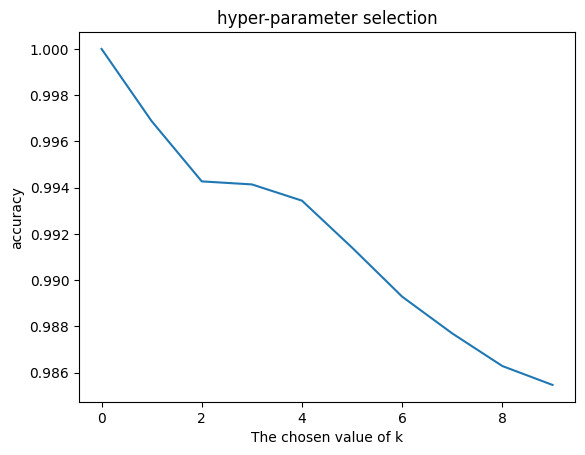

In [45]:
plt.plot(range(10), mean_accuracies)
plt.title('hyper-parameter selection')
plt.xlabel('The chosen value of k')
plt.ylabel('accuracy')
plt.show()

For hyperparameter selection, Here I use K fold. This involves dividing the data into k equally sized subsets, and then training and testing the model k times, each time using a different subset as the test set and the remaining k-1 subsets as the training set. The results are then averaged to give an overall estimate of the model's performance.
